In [1]:
%load_ext autoreload

In [11]:
a.mesh

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


In [2]:
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
import random
import sys

sys.path.insert(1, './classes/')
from elastostatic import *

--> Server: 'https://l.mondaic.com/licensing_server', User: 'andrei.dmitrovskii', Group: 'ETHZ_ERDW_SEG'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.60 seconds]


In [4]:
a = elastostatic_solver(meshfile = "../meshes/elastostatic/mesh.h5")
a.config.run.tensor_order=1
a.construct_mesh(with_surface_topo = False, with_moho_topo = False, 
                 nex =15, buffer = 0, oneD_model="prem_iso_one_crust",
                 local_refinement_level=2, global_refinement_level=2)

a.prepare_mesh_fields(real_or_imag = "re")
a.refine_center_of_the_mesh(tolerance=3481000.) # at the CMB
a.read_gps_data()
a.write_mesh(path = a.meshfile)

./classes/octiload_class.py:95: UserWarning: min_z below CMB, including fluid with mu=0 as elastic
  self.mesh = ms.create_mesh(verbose=True)


number of elements:  12425
refine locally, level 1
rmin 0.9874431015539161, rmax 1.0
number of elements:  40601
refine locally, level 2
rmin 0.9961701459739444, rmax 1.0
number of elements:  138043
amp 0.149373 0.191065
re 7.76159e-05 0.164535
im -2.69163e-05 0.178175
sea_mask_grad 2.04029 7.00137
attaching elastic parameters

SUCCESSFULLY GENERATED MESH IN 9.89639 SECONDS.
r0 has been found
the mesh has been written to ../meshes/elastostatic/mesh.h5


In [5]:
a.mesh.map_nodal_fields_to_element_nodal()

In [6]:
a.run_simulation(stations=a.stations[:1])
a.read_simulation_results(field_names=['re_x', 're_y', 're_z'])

/Users/andrei/miniconda3/envs/salvus/lib/python3.7/site-packages/salvus/flow/sites/__init__.py:109: UserWarning: The version number of the Salvus Python package '0.11.44.post31+g3787c0b3' differs from the version number of site "local": '0.11.44-31-g3787c0b3'. We strongly recommend to use the same version number for both. Otherwise we cannot guarantee that it works as intended.
  skip_version_number_check=skip_version_number_check,


Job `job_2202221908741019_ddcba903e6` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.44-31-g3787c0b3
  * Floating point size: 64


Solving linear system:   0%|                                                                                  …

* Downloaded 110.1 MB of results to `../solutions/elastostatic`.
* Total run time: 20.45 seconds.
* Pure simulation time: 19.11 seconds.


In [14]:
a.prepare_mesh_fields(real_or_imag = "im")
a.write_mesh(path = a.meshfile)
a.run_simulation(stations=a.stations[:1])
a.read_simulation_results(field_names=['im_x', 'im_y', 'im_z'])

./classes/octiload_class.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mesh.write_h5(path)


the mesh has been written to ../meshes/elastostatic/mesh.h5


./classes/elastostatic.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  wall_time_in_seconds = self.config.run.wall_time_in_seconds


Job `job_2202221912242693_d7c5ed4921` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.44-31-g3787c0b3
  * Floating point size: 64


Solving linear system:   0%|                                                                                  …

* Downloaded 110.1 MB of results to `../solutions/elastostatic`.
* Total run time: 21.82 seconds.
* Pure simulation time: 18.73 seconds.


In [56]:
def get_complex_solution(mesh):
    for crd in ['x','y','z']: 
        assert 're_'+crd in mesh.elemental_fields.keys()
        assert 'im_'+crd in mesh.elemental_fields.keys()
        
    for crd in ['x','y','z']:
        # mesh.attach_field("amp_"+crd,  np.sqrt(mesh.elemental_fields['re_'+crd]**2 + 
        #                                          mesh.elemental_fields['im_'+crd]**2) ) 
        # mesh.attach_field("phase_"+crd, np.arctan2(mesh.elemental_fields['re_'+crd],
        #                                              mesh.elemental_fields['im_'+crd]) )
        mesh.attach_field("solution_"+crd, mesh.elemental_fields['re_'+crd]+
                                          1j*mesh.elemental_fields['im_'+crd])
        
def attach_lat_lon_fields(mesh, out=None):
    coords = mesh.points.copy()
    longitudes = np.zeros_like(coords[:,0])
    longitudes[coords[:,0] != 0.] = np.arctan2(coords[:,1][coords[:, 0] != 0.], coords[:,0][coords[:, 0] != 0.])
    latitudes = np.zeros_like(coords[:,0])
    latitudes[np.linalg.norm(coords[:,0:2], axis=-1) != 0] = np.arctan2(coords[:,2], np.linalg.norm(coords[:,0:2], axis=-1))[np.linalg.norm(coords[:,0:2], axis=-1) != 0]
    mesh.attach_field("longitudes", np.degrees(longitudes[mesh.connectivity]))
    mesh.attach_field("latitudes",  np.degrees(latitudes[mesh.connectivity]))
    if out:
        return latitudes[mesh.connectivity], longitudes[mesh.connectivity]

def get_unit_normal(lat, lon):
    sign = np.sign(lat)
    theta = np.radians(90 - np.abs(lat))
    phi = np.radians(lon)
    return np.array([np.sin(theta)*np.cos(phi),
                     np.sin(theta)*np.sin(phi),
                     sign*np.cos(theta)])

def get_surface_solution_matrix(mesh):
    surface_mask       = mesh.side_sets['r1'][0]
    #xyz-surface fields to be rotated
    sol_x = a.mesh.elemental_fields['solution_x'][surface_mask].flatten()
    sol_y = a.mesh.elemental_fields['solution_y'][surface_mask].flatten()
    sol_z = a.mesh.elemental_fields['solution_z'][surface_mask].flatten()
    #matrix is made of pointwise 3d components of the amplitudes
    solution_matrix_surface = np.c_[sol_x, sol_y, sol_z]
    return solution_matrix_surface

def get_unit_vecs_matrix(mesh):
    latitudes    = mesh.elemental_fields['latitudes']
    longitudes   = mesh.elemental_fields['longitudes']
    surface_mask = mesh.side_sets['r1'][0]
    
    surface_latitudes  = latitudes[surface_mask]
    surface_longitudes = longitudes[surface_mask]

    unit_vecs_matrix = np.array([get_unit_normal(lat,lon) for lat,lon in zip(surface_latitudes.flatten(), surface_longitudes.flatten())])
    return unit_vecs_matrix



def attach_surface_field_to_mesh(field, mesh, fieldname, boundname = "r1"):
    surface_mask        = mesh.side_sets[boundname][0]
    surface_nodes_shape = (surface_mask.shape[0], mesh.nodes_per_element)
    mesh_nodes_shape    = (mesh.nelem, mesh.nodes_per_element)
    field_global        = np.zeros(mesh_nodes_shape, dtype=complex)
    field_global[surface_mask] = field.reshape(surface_nodes_shape)
    if ("complex" in str(field.dtype)):
        mesh.attach_field(fieldname+"_re", field_global.real)
        mesh.attach_field(fieldname+"_im", field_global.imag)
        mesh.attach_field(fieldname+"_amp",  np.sqrt(field_global.real**2 + 
                                               field_global.imag**2) ) 
        phases = np.arctan2(field_global.imag, field_global.real)
        mesh.attach_field(fieldname+"_ph", phases)
    else:
        mesh.attach_field(name, field_global)

In [57]:
get_complex_solution(a.mesh)
latitude, longitude = attach_lat_lon_fields(a.mesh, out=1)
solution_surface = get_surface_solution_matrix(a.mesh)
unit_vecs_matrix = get_unit_vecs_matrix(a.mesh)
u_vert_surf = np.array([x.dot(y) for x,y in zip(solution_surface, unit_vecs_matrix)])
attach_surface_field_to_mesh(u_vert_surf, a.mesh, "testtest")

In [58]:
a.write_mesh("test.h5")

./classes/octiload_class.py:117: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mesh.write_h5(path)


the mesh has been written to test.h5


In [122]:
field="displacement"
with h5py.File('../solutions/elastostatic/receivers.h5') as file:
    data = np.array(file['point'][field])

In [107]:
file = h5py.File('../solutions/elastostatic/receivers.h5') 

In [24]:
class stations:
    def get_stations(self,path= "../gps_stations/with_LoadDef/Observed_OTL-induced_Displacements_M2.txt"):
        with open(path) as file:
            header   = file.readline()
            stations = pd.read_csv(file, delim_whitespace=True, index_col=0, header=None, names=header.strip().split(' | ') )

        receivers = [simple_config.receiver.seismology.SideSetPoint3D(latitude=lat, longitude=lon, depth_in_m=0, 
                                             side_set_name='r1', station_code=name, fields=["displacement"]) 
                                             for name, lat, lon in zip(stations.index,stations['Lat(+N,deg)'], stations['Lon(+E,deg)']) ]
        return receivers
    
    def read_loaddef_data(self,path= "../gps_stations/with_LoadDef/Observed_OTL-induced_Displacements_M2.txt"):
        with open(path) as file:
            header   = file.readline()
            stations = pd.read_csv(file, delim_whitespace=True, index_col=0, header=None, names=header.strip().split(' | ') )

        receivers = [simple_config.receiver.seismology.SideSetPoint3D(latitude=lat, longitude=lon, depth_in_m=0, 
                                             side_set_name='r1', station_code=name, fields=["displacement"]) 
                                             for name, lat, lon in zip(stations.index,stations['Lat(+N,deg)'], stations['Lon(+E,deg)']) ]
        station_measurements = { name:         np.array([[lat, lon],[abs(complex(eamp + math.radians(eph))), 
                                                             abs(complex(namp + math.radians(nph))), 
                                                             abs(complex(vamp + math.radians(vph)))]], dtype=list) for name, lat, lon, eamp, eph, namp, nph, vamp, vph in 
                                                                                                                        zip(stations.index
                                                                                                                       , stations['Lat(+N,deg)'], stations['Lon(+E,deg)']
                                                                                                                       , stations['E-Amp(mm)'],   stations['E-Pha(deg)']
                                                                                                                       , stations['N-Amp(mm)'],   stations['N-Pha(deg)']
                                                                                                                       , stations['V-Amp(mm)'],   stations['V-Pha(deg)']) }
        
        return station_measurements
            
    def get_loaddef_data_full(self,path= "../gps_stations/with_LoadDef/Observed_OTL-induced_Displacements_M2.txt"):
        with open(path) as file:
            header   = file.readline()
            stations = pd.read_csv(file, delim_whitespace=True, index_col=0, header=None, names=header.strip().split(' | ') )
        return stations
    
    def get_rotational_matrix(self, theta, phi):
        theta = np.radians(90-theta) #latitude 
        rotx = np.array([[1,             0,              0 ],
                         [0, np.cos(theta), -np.sin(theta) ],
                         [0, np.sin(theta),  np.cos(theta) ] ])

        phi = np.radians(phi) #longitude
        rotz = np.array([[np.cos(phi), -np.sin(phi),   0],
                         [np.sin(phi),  np.cos(phi),   0],
                         [          0,          0,     1]])
        return rotx.dot(rotz)
    
    def rotate_vector(self, vector, crd):
        rotm = self.get_rotational_matrix(crd[0], crd[1]) #lat,lon
        return rotm.dot(vector)
    
    def rotate_displacement_field(self, x_field, y_field, z_field, crd):
        rotmatrix = self.get_rotational_matrix(crd[0], crd[1])
        
        
    def read_receivers_results(self, path = '../solutions/elastostatic/receivers.h5', field="displacement"):
        with h5py.File(path) as file:
            data    = np.array(file['point'][field])[:,:,1]
            stnames = np.array(file['names_ELASTIC_point'], dtype=str)
        result = {}
        for station, record in zip(stnames, data):
            result[station[3:-1]] = record * 1000. # in mm
        return result
    

In [62]:
b=stations()

In [63]:
b.read_receivers_results()

{'ALAR': array([ 0.73360901, -0.08537028, -0.2644062 ]),
 'BATF': array([ 0.26459995, -0.02446166, -0.194837  ]),
 'BABR': array([ 0.2873104 , -0.03967464, -0.15585553]),
 'BAIL': array([ 0.4078914 , -0.03880596, -0.22498539]),
 'BAIR': array([ 0.38509616, -0.06112667, -0.18762287]),
 'BAVC': array([ 0.29787033, -0.02935138, -0.1949425 ]),
 'AMCO': array([ 0.20391319, -0.01812324,  0.06495936]),
 'AMHU': array([ 0.15736937, -0.01076034,  0.03006009]),
 'AMTE': array([ 0.22238275, -0.02252572,  0.05319154]),
 'APSA': array([ 0.77838183, -0.20649597, -0.20920795])}

In [11]:
res = b.read_loaddef_data()

In [252]:
rot_re1 = np.zeros(latitudes.shape)
rot_re1[surface_mask] = rotated_amp[:,0].reshape((surface_mask.shape[0], 125)).real
a.mesh.attach_field('rot_re1', rot_re1)

In [229]:
from gmtplot_class import *

grdimage [WARNING]: x_inc does not divide 180; geographic boundary condition changed to natural.


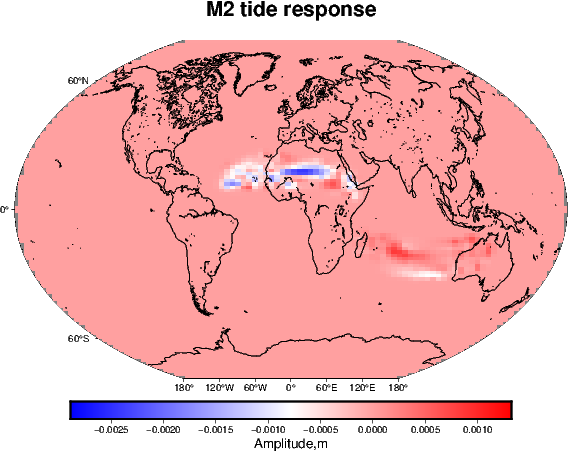

In [265]:
b = gmtplot(a.mesh, field="rot_re1", resolution=100)
b.surface_nodal_indeces()
b.extract_data_from_mesh()
b.get_geographical_coords()
b.interpolate_irregular_grid()
b.make_dataarray()
#b.da = b.da - 6371000.
b.pygmt_plot(name='M2 tide response', colorbar_name='Amplitude,m', cmap="polar", save=True)#"haxby"

In [232]:
rot_re1 = np.zeros(latitudes.shape)
rot_re1[surface_mask] = rotated_amp[:,1].reshape((surface_mask.shape[0], 125)).real
a.mesh.attach_field('rot_re2', rot_re1)

grdimage [WARNING]: x_inc does not divide 180; geographic boundary condition changed to natural.


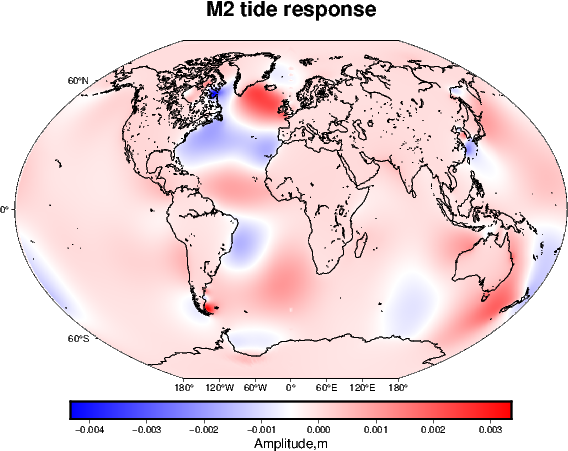

In [233]:
b = gmtplot(a.mesh, field="rot_re2", resolution=1000)
b.surface_nodal_indeces()
b.extract_data_from_mesh()
b.get_geographical_coords()
b.interpolate_irregular_grid()
b.make_dataarray()
#b.da = b.da - 6371000.
b.pygmt_plot(name='M2 tide response', colorbar_name='Amplitude,m', cmap="polar", save=False)#"haxby"

In [234]:
rot_re1 = np.zeros(latitudes.shape)
rot_re1[surface_mask] = rotated_amp[:,2].reshape((surface_mask.shape[0], 125)).real
a.mesh.attach_field('rot_re3', rot_re1)

grdimage [WARNING]: x_inc does not divide 180; geographic boundary condition changed to natural.


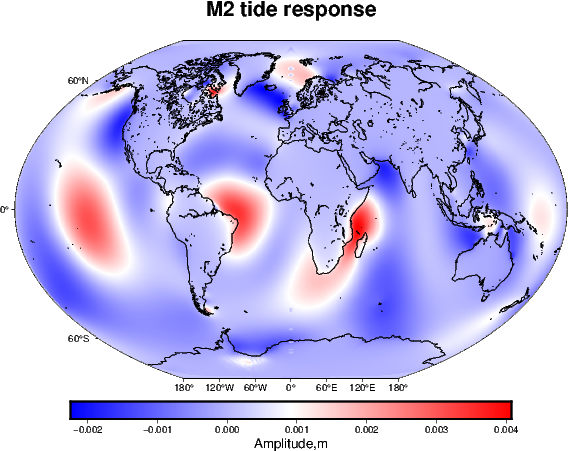

In [235]:
b = gmtplot(a.mesh, field="rot_re3", resolution=1000)
b.surface_nodal_indeces()
b.extract_data_from_mesh()
b.get_geographical_coords()
b.interpolate_irregular_grid()
b.make_dataarray()
#b.da = b.da - 6371000.
b.pygmt_plot(name='M2 tide response', colorbar_name='Amplitude,m', cmap="polar", save=False)#"haxby"